### Problem Statement:

This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

#### Description of fnlwgt (final weight)

The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

1. A single cell estimate of the population 16+ for each state.

2. Controls for Hispanic Origin by age and sex.

3. Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

#### Prediction:
The prediction task is to determine whether a person makes over $50K a year.

In [124]:
import pandas as pd # for handling dataset
import numpy as np  # for mathematical computation

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from scipy.stats import skew

# for visualization
import matplotlib.pyplot as plt

import seaborn as sns
import pickle

import warnings
warnings.filterwarnings('ignore')

In [128]:
# Loading dataset
df = pd.read_csv(r"C:\Users\admin\Desktop\Python basis\Eve\census_income.csv")
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [129]:
# Checking data type and null value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [131]:
# checkng shape
df.shape

(32560, 15)

There are 32560 rows and 15 columns

In [132]:
# checking missing value
df.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

There is no any missing value in our dataset

In [133]:
# to list categorical features in our dataset
cat_features=[i for i in df.columns if df.dtypes[i]=='object']
cat_features

['Workclass',
 'Education',
 'Marital_status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Native_country',
 'Income']

In [134]:
# to list continous features in our dataset
con_features=[i for i in df.columns if df.dtypes[i]=='int64']
con_features

['Age',
 'Fnlwgt',
 'Education_num',
 'Capital_gain',
 'Capital_loss',
 'Hours_per_week']

In [135]:
# to count number of unique values in each columns 
df.nunique()

Age                  73
Workclass             9
Fnlwgt            21647
Education            16
Education_num        16
Marital_status        7
Occupation           15
Relationship          6
Race                  5
Sex                   2
Capital_gain        119
Capital_loss         92
Hours_per_week       94
Native_country       42
Income                2
dtype: int64

In [136]:
df.describe() # to get high understanding of dataset or to get overview/stats of the dataset

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


#### Capital_gain and Capital_loss data is messed up as their standard deviation value is greater than mean value.

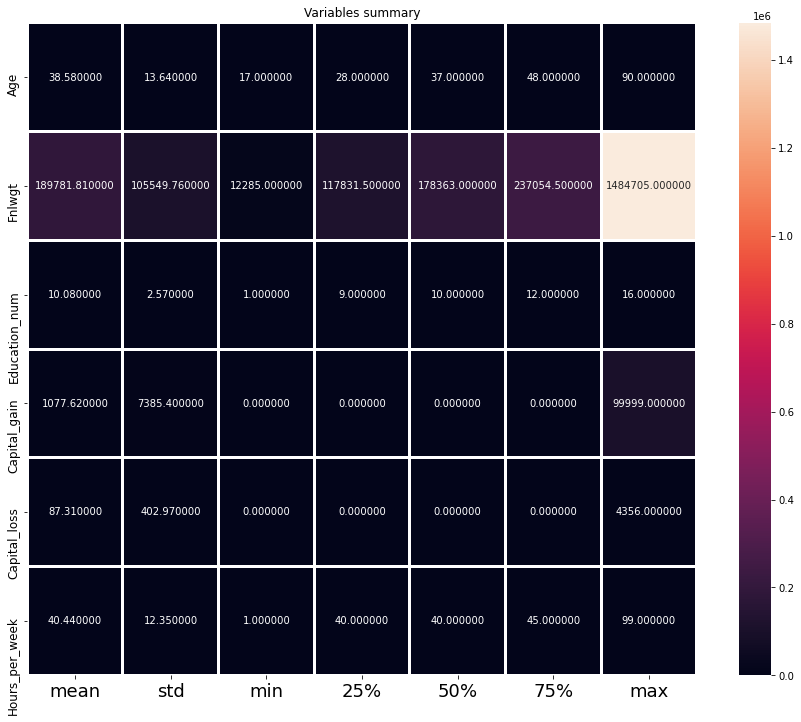

In [137]:
plt.figure(figsize=(15,12))
sns.heatmap(round(df.describe()[1:].transpose(),2),linewidth=2,annot=True,fmt='f')
plt.xticks(fontsize=18)
plt.yticks(fontsize=12)
plt.title("Variables summary")
plt.show()

From the above plotting we are determining mean, standard deviation, minimum and maximum values of each column. It helps us further in data cleaning.

In [138]:
# to count sum of zeros (0's) present
print('Total no of zeros in Capital_gain are:',sum(df['Capital_gain']==0))
print('Total no of zeros in Capital_loss are:',sum(df['Capital_loss']==0))

Total no of zeros in Capital_gain are: 29849
Total no of zeros in Capital_loss are: 31041


In [139]:
# dropping column as they have above 90% missing values
df=df.drop(columns=['Capital_gain','Capital_loss'])

In [140]:
# dropping Education_num as it is same as Education feature.
df=df.drop(columns=['Education_num'])

In [141]:
# to know series containing the counts of unique values
df['Education'].value_counts()

 HS-grad         10501
 Some-college     7291
 Bachelors        5354
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: Education, dtype: int64

In [142]:
# appending duplicate values into one
df['Education']=df['Education'].replace(['1st-4th','5th-6th','7th-8th','9th','10th','11th','12th','Preschool'],'School',regex=True)

In [143]:
df['Marital_status'].value_counts()

 Married-civ-spouse       14976
 Never-married            10682
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: Marital_status, dtype: int64

In [144]:
# appending duplicate values into one
df['Marital_status']=df['Marital_status'].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'],'Married',regex=True)

In [145]:
df['Workclass'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64

In [146]:
# filling '?' with highest count of occurences
df['Workclass']=df['Workclass'].str.replace('?','Private',regex=True)

In [147]:
df['Occupation'].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3769
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Occupation, dtype: int64

In [148]:
# filling '?' with highest count of occurences
df['Occupation']=df['Occupation'].str.replace('?','Prof-specialty',regex=True)

In [149]:
df['Native_country'].value_counts()

 United-States                 29169
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

In [150]:
# filling '?' with highest count of occurences
df['Native_country']=df['Native_country'].str.replace('?','United-States',regex=True)

In [151]:
df_new=df[['Age','Fnlwgt','Hours_per_week']]

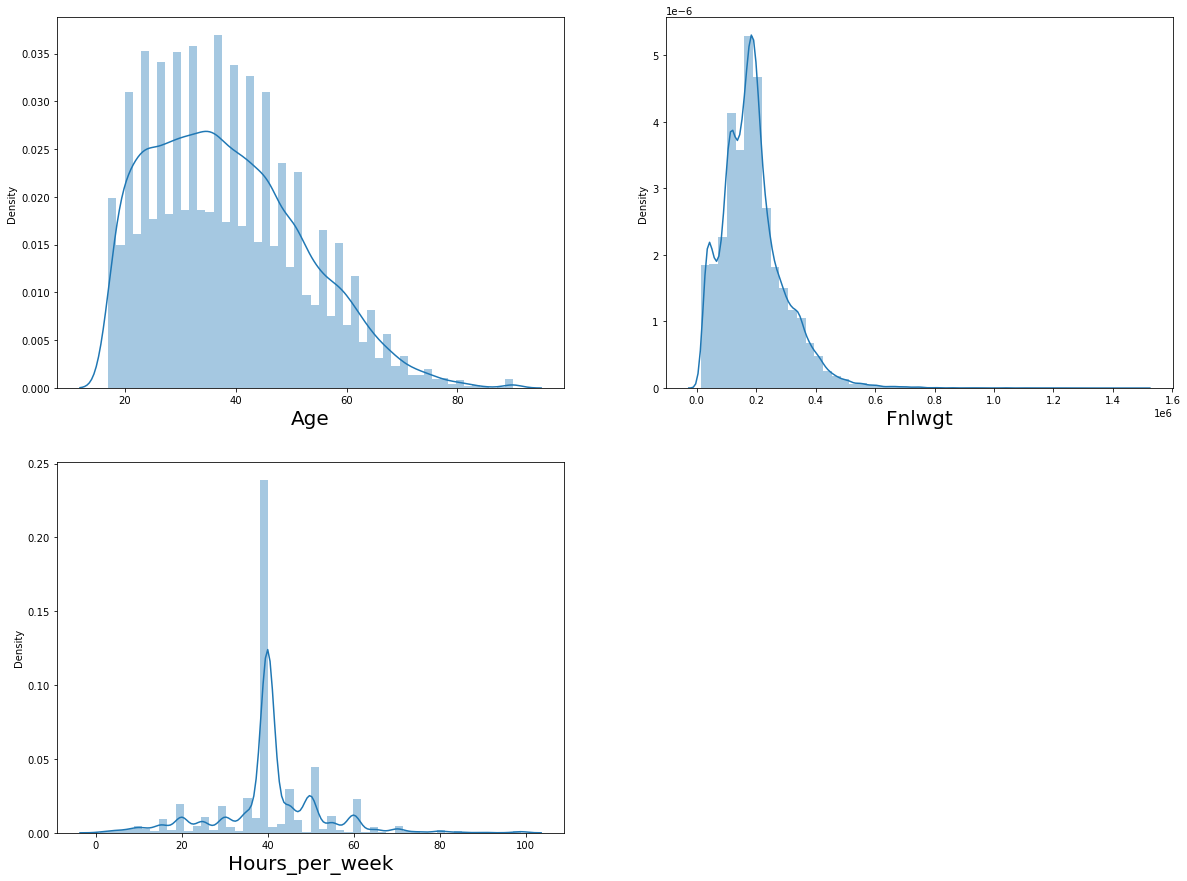

In [152]:
# lets visualize how data is distributed in every continous column 
plt.figure(figsize=(20,15), facecolor='white')
plotnumber=1
for column in df_new:
    if plotnumber<=4:
        ax=plt.subplot(2,2,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.show()

For Age little skewness can be seen,Fnlwgt and Hours_per_week has skewness.

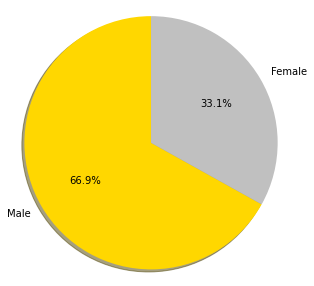

In [153]:
# to visualize column 'type' in pie chart

labels = ['Male', 'Female']

fig, ax = plt.subplots(figsize=(5,5))
colors = ['gold', 'silver']
ax.pie(df['Sex'].value_counts(),  labels=labels, autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)

ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

<AxesSubplot:xlabel='Income', ylabel='count'>

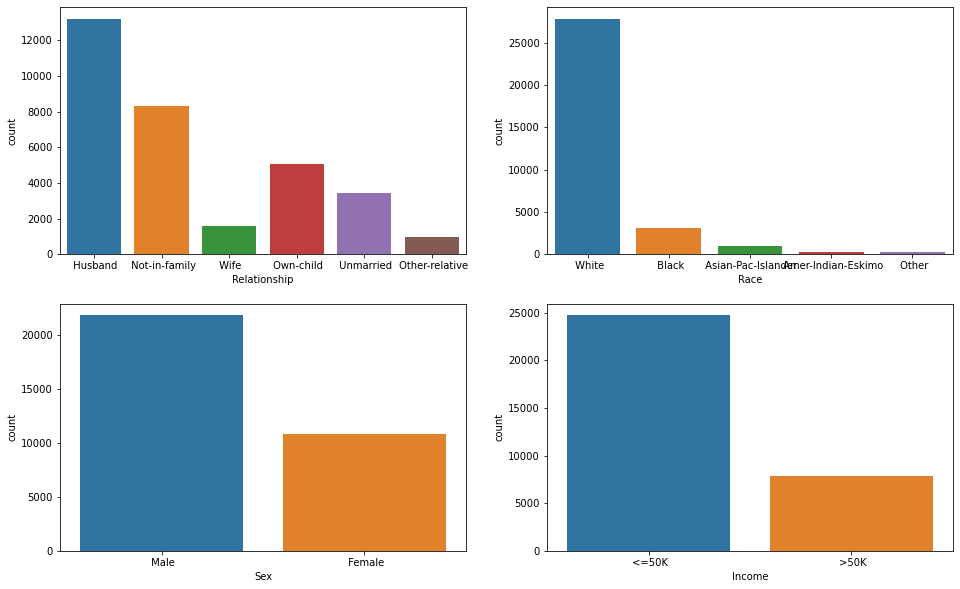

In [154]:
fig,ax = plt.subplots(2,2,figsize=(16,10))
sns.countplot('Relationship',data=df,ax=ax[0][0])
sns.countplot('Race',data=df,ax=ax[0][1])
sns.countplot('Sex',data=df,ax=ax[1][0])
sns.countplot('Income',data=df,ax=ax[1][1])

from above plots
1- In Relationship category, husband has the highest count.

2- In race white people are large in numbers.

3- Count of male is more than females.

4- Few number of people falls in the category of making >$50k a year.

In [156]:
df['Occupation'].value_counts()

 Prof-specialty       5983
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3769
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Occupation, dtype: int64

In [157]:
# shortening variables 
df['Occupation']=df['Occupation'].replace('Transport-moving','Transport',regex=True)
df['Occupation']=df['Occupation'].replace('Exec-managerial','Manager',regex=True)
df['Occupation']=df['Occupation'].replace(['Protective-serv','Priv-house-serv'],'Servant',regex=True)
df['Occupation']=df['Occupation'].replace('Prof-specialty','Professor',regex=True)
df['Occupation']=df['Occupation'].replace('Machine-op-inspct','Machine-Operator',regex=True)

<AxesSubplot:xlabel='Occupation', ylabel='count'>

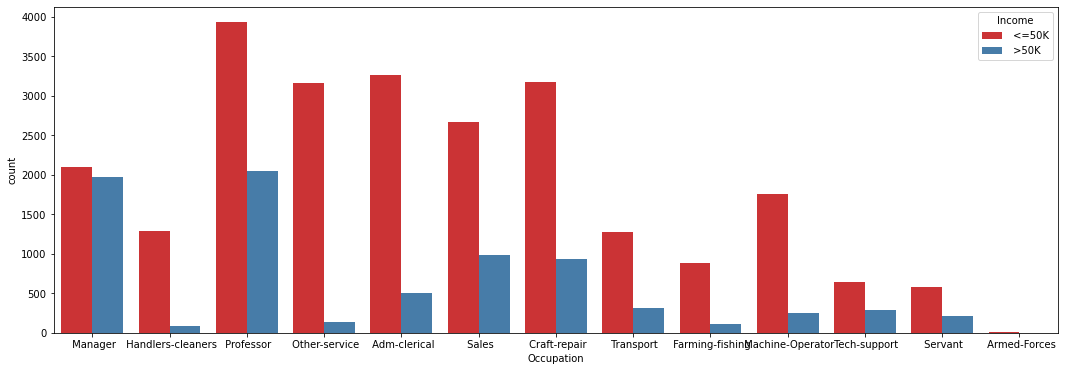

In [158]:
plt.subplots(figsize=(18,6))
sns.countplot(x='Occupation',hue='Income',data=df, palette='Set1')

Professor & Manager are making more than $50k/year from others.

<AxesSubplot:xlabel='Race', ylabel='count'>

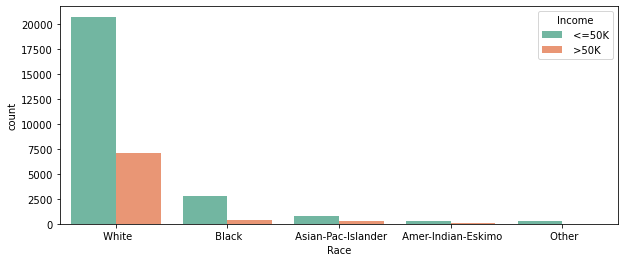

In [159]:
plt.subplots(figsize=(10,4))
sns.countplot(x='Race',hue='Income',data=df, palette='Set2')

Except white people there is only few different race people who earns more than $50k/year.<a class="anchor-link" href="#Except-white-people-there-is-only-few-different-race-people-who-earns-more-than-$50k/year.

<AxesSubplot:xlabel='Education', ylabel='count'>

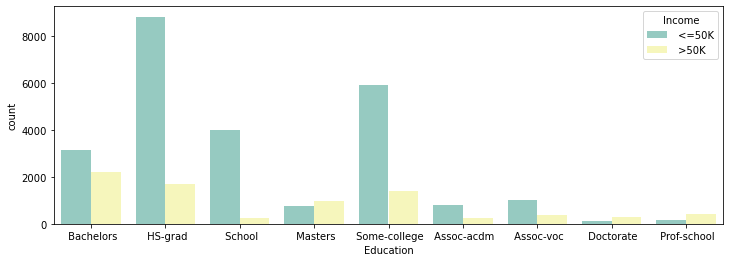

In [160]:
plt.subplots(figsize=(12,4))
sns.countplot(x='Education',hue='Income',data=df, palette='Set3')

<AxesSubplot:xlabel='Workclass', ylabel='count'>

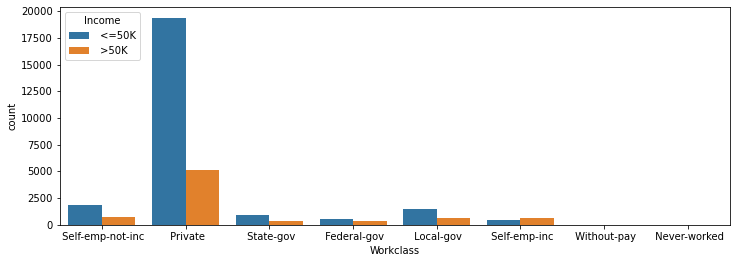

In [162]:
plt.subplots(figsize=(12,4))
sns.countplot(x='Workclass',hue='Income',data=df)

People working in private tops the occupation list for earning >50k a year.

In [163]:
# converting objects into integers
lab_enc = LabelEncoder()
list1 = ['Workclass','Education','Marital_status','Occupation','Relationship','Race','Sex','Native_country','Income']
for val in list1:
    df[val] = lab_enc.fit_transform(df[val].astype(str))

In [164]:
# to see skewness for every continous column stored in con_datanew
for col in df:
    print(col)
    print(skew(df[col]))

Age
0.5587118988154982
Workclass
0.07617495765456885
Fnlwgt
1.4469055818253151
Education
-0.0436639783408086
Marital_status
0.7023957554213066
Occupation
-0.27750719494681225
Relationship
0.7867473090814343
Race
-2.4352196663495116
Sex
-0.7192106431922183
Hours_per_week
0.2276253044722967
Native_country
-4.242887484296264
Income
1.212327081863191


In [165]:
# removing the skewness for continous data feature
q = df['Fnlwgt'].quantile(0.96)
# removing the top 4% data from the Fnlwgt column
df= df[df['Fnlwgt']<q]

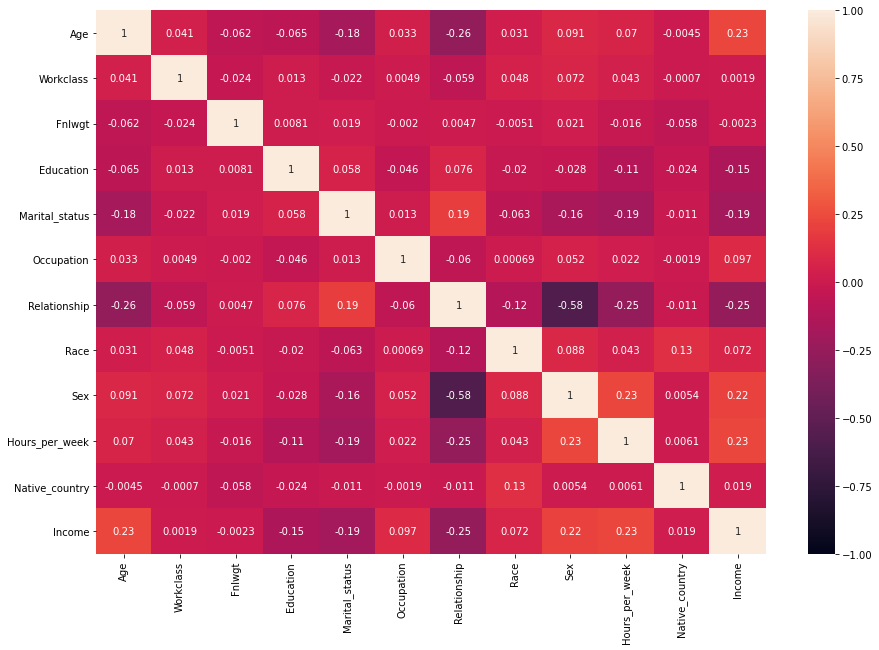

In [166]:
# plotting heatmap to observe the correlation
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, vmin=-1.0, vmax=1.0)
plt.show()

Age and Hours_per_week shows good relation with target/label (Income) variable.

In [182]:
y = df['Income']
X = df.drop('Income', axis = 1)

In [183]:
# Data Scaling.  Formula Z=(x-mean)/std
scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

In [184]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(X_scaled, i) for i in range (X_scaled.shape[1])]
vif["features"] = X.columns

#let's check the values
vif

,vif,features
0,1.109856,Age
1,1.009780,Workclass
2,1.008956,Fnlwgt
3,1.022149,Education
4,1.087831,Marital_status
5,1.007221,Occupation
6,1.678039,Relationship
7,1.034513,Race
8,1.559521,Sex
9,1.114090,Hours_per_week


No Multi-collinearity problem exists

In [185]:
# Split data into train and test. Model will be built on training data and tested on test data
x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size = 0.25, random_state = 101)

### Logistic Regression

In [186]:
log_reg = LogisticRegression()
log_reg.fit(x_train,y_train)

LogisticRegression()

In [187]:
y_pred = log_reg.predict(x_test)

In [188]:
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.7685220729366603

In [189]:
# Confusion Matrix
conf_mat =confusion_matrix(y_test,y_pred)
conf_mat

array([[5564,  336],
       [1473,  442]], dtype=int64)

In [190]:
print('\n----------------Classification Report-------------------')
print (classification_report(y_test,y_pred,digits=2))


----------------Classification Report-------------------
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      5900
           1       0.57      0.23      0.33      1915

    accuracy                           0.77      7815
   macro avg       0.68      0.59      0.59      7815
weighted avg       0.74      0.77      0.73      7815



In [191]:
# Cross Validation score to check if the model is overfitting or underfitting
score= cross_val_score(log_reg,X,y,cv=5)

print("\n=============== Cross Validation Score ===================")
print(score)
print(score.mean())
print(score.std())


=============== Cross Validation Score ===================
[0.75799744 0.75799744 0.7581187  0.7581187  0.75795873]
0.7580382020514593
6.723015231176797e-05


#### Decision Tree Classifier

In [192]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(x_train,y_train)
pred=dt_clf.predict(x_train)
dt_clf_report = pd.DataFrame(classification_report(y_train,pred, output_dict=True))

print("\n===================Train Result======================")

print(f"Accuracy Score: {accuracy_score(y_train,pred) * 100:.2f}%")
print("______________________________________________")
print(f"CLASSIFICATION REPORT:\n{dt_clf_report}")
print("______________________________________________")
print(f"Confusion Matrix:\n {confusion_matrix(y_train,pred)}\n")

#*********************** Test Score *************************

pred = dt_clf.predict(x_test)  
dt_clf_report = pd.DataFrame(classification_report(y_test,pred, output_dict=True))
print("\n===================Test Result======================")
print(f"Accuracy Score: {accuracy_score(y_test,pred) * 100:.2f}%")
print("______________________________________________")
print(f"CLASSIFICATION REPORT:\n{dt_clf_report}")
print("______________________________________________")
print(f"Confusion Matrix:\n {confusion_matrix(y_test,pred)}\n")


===================Train Result======================
Accuracy Score: 100.00%
______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999944     1.000000  0.999957      0.999972      0.999957
recall         1.000000     0.999823  0.999957      0.999911      0.999957
f1-score       0.999972     0.999911  0.999957      0.999942      0.999957
support    17794.000000  5648.000000  0.999957  23442.000000  23442.000000
______________________________________________
Confusion Matrix:
 [[17794     0]
 [    1  5647]]


===================Test Result======================
Accuracy Score: 77.97%
______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy   macro avg  weighted avg
precision     0.854068     0.550392  0.779655     0.70223      0.779655
recall        0.854068     0.550392  0.779655     0.70223      0.779655
f1-score      0

In [193]:
# Cross Validation score to check if the model is overfitting or underfitting
score= cross_val_score(dt_clf,X,y,cv=5)

print("\n=============== Cross Validation Score ===================")
print(score)
print(score.mean())
print(score.std())


=============== Cross Validation Score ===================
[0.77415227 0.76663468 0.77347624 0.77443609 0.77555591]
0.7728510386514742
0.0031798101957683377


#### Random Forest Classifier

In [194]:
rand_clf = RandomForestClassifier(random_state=101)
rand_clf.fit(x_train,y_train)
pred=dt_clf.predict(x_train)
rand_clf_report = pd.DataFrame(classification_report(y_train,pred, output_dict=True))

print("\n===================Train Result======================")

print(f"Accuracy Score: {accuracy_score(y_train,pred) * 100:.2f}%")
print("______________________________________________")
print(f"CLASSIFICATION REPORT:\n{rand_clf_report}")
print("______________________________________________")
print(f"Confusion Matrix:\n {confusion_matrix(y_train,pred)}\n")

#*********************** Test Score *************************

pred = rand_clf.predict(x_test)  
rand_clf_report = pd.DataFrame(classification_report(y_test,pred, output_dict=True))
print("\n===================Test Result======================")
print(f"Accuracy Score: {accuracy_score(y_test,pred) * 100:.2f}%")
print("______________________________________________")
print(f"CLASSIFICATION REPORT:\n{rand_clf_report}")
print("______________________________________________")
print(f"Confusion Matrix:\n {confusion_matrix(y_test,pred)}\n")


===================Train Result======================
Accuracy Score: 100.00%
______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999944     1.000000  0.999957      0.999972      0.999957
recall         1.000000     0.999823  0.999957      0.999911      0.999957
f1-score       0.999972     0.999911  0.999957      0.999942      0.999957
support    17794.000000  5648.000000  0.999957  23442.000000  23442.000000
______________________________________________
Confusion Matrix:
 [[17794     0]
 [    1  5647]]


===================Test Result======================
Accuracy Score: 82.53%
______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.864491     0.672522  0.825336     0.768507      0.817451
recall        0.911525     0.559791  0.825336     0.735658      0.825336
f1-score    

In [195]:
# Cross Validation score to check if the model is overfitting or underfitting
score= cross_val_score(rand_clf,X,y,cv=5)

print("\n=============== Cross Validation Score ===================")
print(score)
print(score.mean())
print(score.std())


=============== Cross Validation Score ===================
[0.82213692 0.82117722 0.82418813 0.82818749 0.82594785]
0.8243275215440897
0.00254036912251618


#### Using GridSearchCV for hyper parameter tuning on best model (Random Forest Classifier) as its CV score & accuracy score is having least difference

In [210]:
# we are tuning three hyperparameters right now, we are passing different values for both parameters
grid_param = {
    'max_depth' : range(2,20,3),              
    'min_samples_leaf' : range (1,20,2),
    'min_samples_split' : range (2,20,2)
}

In [211]:
grid_search = GridSearchCV(estimator=rand_clf,
                          param_grid=grid_param,
                          cv=3,
                          n_jobs =-1)

In [212]:
grid_search.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=101),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 20, 3),
                         'min_samples_leaf': range(1, 20, 2),
                         'min_samples_split': range(2, 20, 2)})

In [213]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'max_depth': 14, 'min_samples_leaf': 5, 'min_samples_split': 14}


In [214]:
rand_clf = RandomForestClassifier(max_depth =14, min_samples_leaf=5, min_samples_split=14)
rand_clf.fit(x_train,y_train)

RandomForestClassifier(max_depth=14, min_samples_leaf=5, min_samples_split=14)

In [215]:
rand_clf.score(x_test,y_test)

0.838131797824696

After doing hyper parameter tuning on random forest classifier, score improves by 2.5%.

#### KNN Classifier

In [216]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)
pred=knn.predict(x_train)
knn_report = pd.DataFrame(classification_report(y_train,pred, output_dict=True))

print("\n===================Train Result======================")

print(f"Accuracy Score: {accuracy_score(y_train,pred) * 100:.2f}%")
print("______________________________________________")
print(f"CLASSIFICATION REPORT:\n{knn_report}")
print("______________________________________________")
print(f"Confusion Matrix:\n {confusion_matrix(y_train,pred)}\n")

#*********************** Test Score *************************

pred = knn.predict(x_test)  
knn_report = pd.DataFrame(classification_report(y_test,pred, output_dict=True))
print("\n===================Test Result======================")
print(f"Accuracy Score: {accuracy_score(y_test,pred) * 100:.2f}%")
print("______________________________________________")
print(f"CLASSIFICATION REPORT:\n{knn_report}")
print("______________________________________________")
print(f"Confusion Matrix:\n {confusion_matrix(y_test,pred)}\n")


===================Train Result======================
Accuracy Score: 88.20%
______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.911455     0.778185  0.882007      0.844820      0.879346
recall         0.935428     0.713704  0.882007      0.824566      0.882007
f1-score       0.923286     0.744551  0.882007      0.833919      0.880223
support    17794.000000  5648.000000  0.882007  23442.000000  23442.000000
______________________________________________
Confusion Matrix:
 [[16645  1149]
 [ 1617  4031]]


===================Test Result======================
Accuracy Score: 79.54%
______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.855044     0.589875  0.795393     0.722459      0.790066
recall        0.877797     0.541514  0.795393     0.709655      0.795393
f1-score     

In [217]:
# Cross Validation score to check if the model is overfitting or underfitting
score= cross_val_score(knn,X,y,cv=5)

print("\n=============== Cross Validation Score ===================")
print(score)
print(score.mean())
print(score.std())


=============== Cross Validation Score ===================
[0.70953295 0.71641075 0.70516717 0.70644697 0.70452728]
0.708417023077971
0.004352418015833271


#### SVC

In [218]:
svc = SVC(kernel = 'poly',C=5)
svc.fit(x_train,y_train)
pred=svc.predict(x_train)
svc_report = pd.DataFrame(classification_report(y_train,pred, output_dict=True))

print("\n===================Train Result======================")

print(f"Accuracy Score: {accuracy_score(y_train,pred) * 100:.2f}%")
print("______________________________________________")
print(f"CLASSIFICATION REPORT:\n{svc_report}")
print("______________________________________________")
print(f"Confusion Matrix:\n {confusion_matrix(y_train,pred)}\n")

#*********************** Test Score *************************

pred = svc.predict(x_test)  
svc_report = pd.DataFrame(classification_report(y_test,pred, output_dict=True))
print("\n===================Test Result======================")
print(f"Accuracy Score: {accuracy_score(y_test,pred) * 100:.2f}%")
print("______________________________________________")
print(f"CLASSIFICATION REPORT:\n{svc_report}")
print("______________________________________________")
print(f"Confusion Matrix:\n {confusion_matrix(y_test,pred)}\n")


===================Train Result======================
Accuracy Score: 78.45%
______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.798138     0.644133  0.784532      0.721135      0.761033
recall         0.958582     0.236190  0.784532      0.597386      0.784532
f1-score       0.871033     0.345641  0.784532      0.608337      0.744447
support    17794.000000  5648.000000  0.784532  23442.000000  23442.000000
______________________________________________
Confusion Matrix:
 [[17057   737]
 [ 4314  1334]]


===================Test Result======================
Accuracy Score: 77.98%
______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.794503     0.634722  0.779782     0.714613      0.755350
recall        0.955424     0.238642  0.779782     0.597033      0.779782
f1-score     

#### Gradient Boosting Classifier

In [219]:
gbdt_clf = GradientBoostingClassifier()
gbdt_clf.fit(x_train,y_train)
pred=gbdt_clf.predict(x_train)
gbdt_clf_report = pd.DataFrame(classification_report(y_train,pred, output_dict=True))

print("\n===================Train Result======================")

print(f"Accuracy Score: {accuracy_score(y_train,pred) * 100:.2f}%")
print("______________________________________________")
print(f"CLASSIFICATION REPORT:\n{gbdt_clf_report}")
print("______________________________________________")
print(f"Confusion Matrix:\n {confusion_matrix(y_train,pred)}\n")

#*********************** Test Score *************************

pred = gbdt_clf.predict(x_test)  
gbdt_clf_report = pd.DataFrame(classification_report(y_test,pred, output_dict=True))
print("\n===================Test Result======================")
print(f"Accuracy Score: {accuracy_score(y_test,pred) * 100:.2f}%")
print("______________________________________________")
print(f"CLASSIFICATION REPORT:\n{gbdt_clf_report}")
print("______________________________________________")
print(f"Confusion Matrix:\n {confusion_matrix(y_test,pred)}\n")


===================Train Result======================
Accuracy Score: 84.23%
______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.869522     0.723546  0.842334      0.796534      0.834351
recall         0.932168     0.559313  0.842334      0.745741      0.842334
f1-score       0.899756     0.630917  0.842334      0.765336      0.834983
support    17794.000000  5648.000000  0.842334  23442.000000  23442.000000
______________________________________________
Confusion Matrix:
 [[16587  1207]
 [ 2489  3159]]


===================Test Result======================
Accuracy Score: 84.01%
______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.867763     0.722706  0.840051     0.795235      0.832218
recall        0.929831     0.563446  0.840051     0.746638      0.840051
f1-score     

In [220]:
# Cross Validation score to check if the model is overfitting or underfitting
score= cross_val_score(gbdt_clf,X,y,cv=5)

print("\n=============== Cross Validation Score ===================")
print(score)
print(score.mean())
print(score.std())


=============== Cross Validation Score ===================
[0.83557262 0.83413308 0.83682611 0.84754439 0.84018557]
0.8388523530412997
0.004784619678006016


#### PCA

In [221]:
scaler = StandardScaler()
X=df.drop('Income', axis=1)
X_scaled = scaler.fit_transform(X)

In [222]:
pca=PCA()
pca.fit_transform(X_scaled)

array([[-0.89991644, -1.06682667,  0.31902186, ..., -0.05233131,
        -1.9997123 , -0.06403925],
       [-1.05909226, -0.20148748, -0.11095056, ..., -0.10300636,
        -0.99004873,  0.23327467],
       [-0.78130029,  1.33577581, -0.07696201, ..., -1.92302747,
         0.06422267, -0.07712987],
       ...,
       [ 2.26595727, -0.98580902,  0.39859307, ...,  0.14924762,
         2.55975014,  0.63183775],
       [ 1.44976108, -0.51368853, -1.2359709 , ...,  0.17680237,
        -1.25571259,  0.90100085],
       [ 1.41163016, -0.49013165,  0.55597367, ..., -0.48366212,
         0.74513144,  0.87130843]])

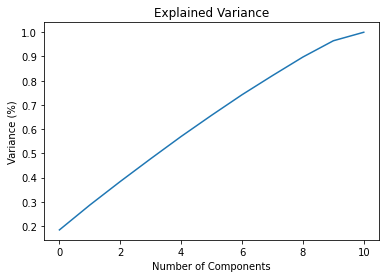

In [223]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.title('Explained Variance')
plt.show()

we can see that 90% of the variance is being explained by 8 components

In [225]:
pca=PCA(n_components=8)
new_data=pca.fit_transform(X_scaled)

principal_x=pd.DataFrame(new_data,columns=['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8'])

In [226]:
principal_x

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8
0,-0.899916,-1.066827,0.319022,0.990644,-1.449240,0.482156,0.857594,1.634046
1,-1.059092,-0.201487,-0.110951,0.057948,1.119888,0.114140,0.437155,-0.397505
2,-0.781300,1.335776,-0.076962,1.019525,0.330425,-0.900602,0.067211,0.218233
3,2.506563,5.122116,1.505170,-0.173706,0.250916,2.185733,1.112845,-0.833503
4,1.898481,-0.350572,0.151388,-0.475206,0.799270,0.742890,1.301068,-1.182482
...,...,...,...,...,...,...,...,...
31252,1.753049,-0.457241,1.257287,-2.258222,-0.106666,1.578758,1.017006,-0.991133
31253,-1.121138,-0.348183,-0.107411,0.004354,0.244676,-0.237493,-0.149657,0.393601
31254,2.265957,-0.985809,0.398593,0.590495,0.298272,0.341439,0.189715,2.364195
31255,1.449761,-0.513689,-1.235971,0.066275,1.051866,0.208333,-0.318154,1.463725


#### Lets plot ROC AUC Curve to choose the best model

In [227]:
# Plot ROC/AUC for multiple models without hyperparams tuning

lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
kn = KNeighborsClassifier()
gbdt = GradientBoostingClassifier()
sgd= SGDClassifier()

In [228]:
# training with all classifier
lr.fit(x_train,y_train)
rf.fit(x_train,y_train)
dt.fit(x_train,y_train)
kn.fit(x_train,y_train)
gbdt.fit(x_train,y_train)
sgd.fit(x_train,y_train)

print('All models are trained')

All models are trained


All models are trained

In [229]:
# All models score captured
lr.fit(x_test,y_test)
rf.fit(x_test,y_test)
dt.fit(x_test,y_test)
kn.fit(x_test,y_test)
gbdt.fit(x_test,y_test)
sgd.fit(x_test,y_test)

print('All models test score captured')

All models test score captured


#### Lets find ROC AUC score

In [230]:
# LogisticRegression
roc_auc_score(y_test,lr.predict(x_test))

0.5968493605345843

In [231]:
# DecisionTreeClassifier
roc_auc_score(y_test,dt.predict(x_test))

1.0

In [232]:
# RandomForestClassifier
roc_auc_score(y_test,rf.predict(x_test))

0.9994778067885117

In [233]:
# KneighborsClassifier
roc_auc_score(y_test,kn.predict(x_test))

0.7912424215603842

In [234]:
# GradientBoostingClassifier
roc_auc_score(y_test,gbdt.predict(x_test))

0.7681424525379476

#### Lets check ROC AUC curve for the fitted model

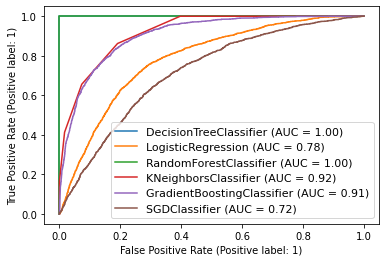

In [235]:
disp = plot_roc_curve(dt,x_test,y_test)
plot_roc_curve(lr,x_test,y_test,ax=disp.ax_)
plot_roc_curve(rf,x_test,y_test,ax=disp.ax_)
plot_roc_curve(kn,x_test,y_test,ax=disp.ax_)
plot_roc_curve(gbdt,x_test,y_test,ax=disp.ax_)
plot_roc_curve(sgd,x_test,y_test,ax=disp.ax_)
plt.legend(prop={'size':11}, loc='lower right')
plt.show()


#### Model Saving

In [236]:
# saving the model to local system
filename = 'Census Income.pickle'
pickle.dump(rand_clf,open(filename,'wb'))